In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import MDAnalysis as mda
import string

In [3]:
data_colvar = plumed.read_as_pandas("COLVAR")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1489/1337164673.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar = plumed.read_as_pandas("COLVAR")


Text(0.5, 0, 'Time [ns]')

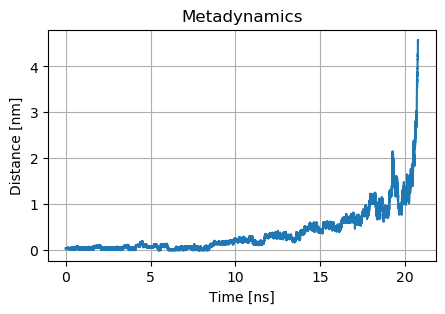

In [4]:
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_colvar["time"]*0.001, data_colvar["d1"])
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")

Text(0.5, 0, 'Axial distance fps.lp [nm]')

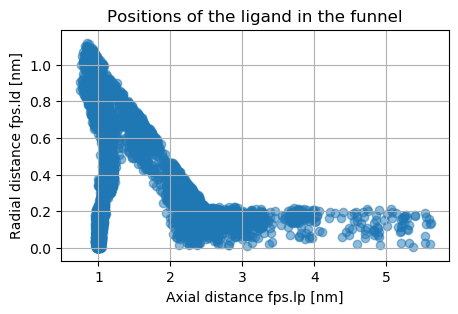

In [7]:
plt.scatter(data_colvar["fps.lp"], data_colvar["fps.ld"], linewidths=1, alpha=0.5)
plt.grid()
plt.title("Positions of the ligand in the funnel")
plt.ylabel("Radial distance fps.ld [nm]")
plt.xlabel("Axial distance fps.lp [nm]")

Text(0.5, 0, 'Time [ns]')

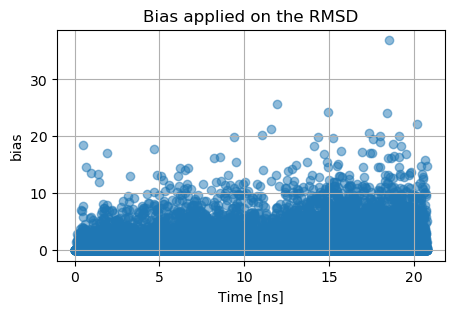

In [9]:
plt.scatter(data_colvar["time"]*0.001, data_colvar["uwall-rmsd.bias"], linewidths=1, alpha=0.5)
plt.grid()
plt.title("Bias applied on the RMSD")
plt.ylabel("bias")
plt.xlabel("Time [ns]")

Text(0.5, 0, 'Time [ns]')

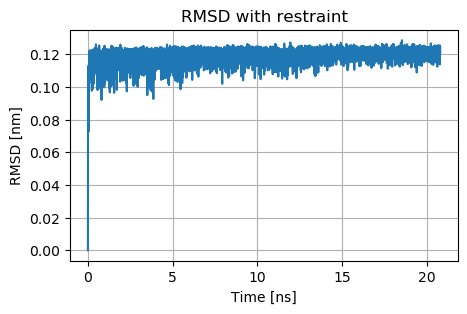

In [15]:
plt.plot(data_colvar["time"]*0.001, data_colvar["rmsd"])
plt.grid()
plt.title("RMSD with restraint")
plt.ylabel("RMSD [nm]")
plt.xlabel("Time [ns]")

# Analysis on the fitted trajectory

In [3]:
PDB = 'ref_nowat.pdb'
XTC = 'trj_fit.xtc'
u = mda.Universe(str(PDB), str(XTC)) #we create the universe

In [19]:
# Define the selection for the group of atoms and single atom
group_selection = "index 1175 or index 1196 or index 1222 or index 1245 or index 1330 or index 1331"  # Coordinant oxygens
calcium_ion = "resid 301"  

# Select the group of atoms and single atom
group_atoms = u.select_atoms(group_selection)
CAL = u.select_atoms(calcium_ion)

# Iterate through trajectory frames
distances = []
for ts in u.trajectory:
    # Compute distances between group of atoms and single atom
    distances.append(np.linalg.norm(group_atoms.center_of_mass() - CAL.positions))

In [35]:
len(distances)

2080

Text(0.5, 0, 'Time [ns]')

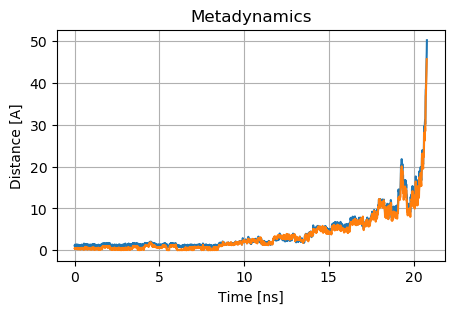

In [39]:
times = np.arange(len(distances))*0.01
plt.plot(times, distances)
plt.plot(data_colvar["time"][0::10]*0.001, data_colvar["d1"][::10]*10)
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [A]")
plt.xlabel("Time [ns]")

# a primo sguardo non sembrano esattamente sovrapposte, ma questo 
# è dovuto al fatto che i dati che vengono da COLVAR sono di più!
# Puoi risolvere tutto mettendo 

# Cluster analysis for the 8 configurations

In [3]:
from sklearn.cluster import KMeans
from MDAnalysis.analysis.rms import RMSD

In [59]:
pocket = "resid 70-90 and backbone"  # Example selection for residues 10 to 30 (backbone atoms)
sel_pocket = u.select_atoms(pocket)

rmsd_values = []

rmsd = mda.analysis.rms.RMSD(sel_pocket).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0.5, 0, 'Time [ns]')

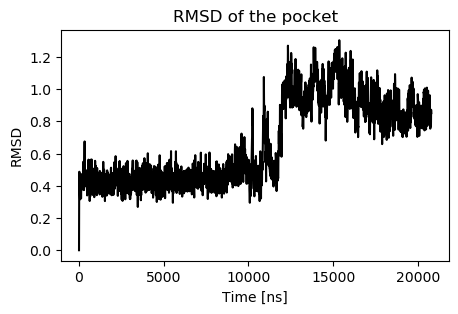

In [67]:
rmsd_values = rmsd.rmsd.T   # transpose makes it easier for plotting
time = rmsd_values[1]
plt.plot(time, rmsd_values[2], 'k-',  label="all")
plt.ylabel("RMSD [A]")
plt.title("RMSD of the pocket")
plt.xlabel("Time [ns]")

# fai attenzione perché l'RMSD è in Angstrom

In [86]:
# Select the element below a threshold 
rmsd_cut = []
dist_cut = []
time_cut = []
labels_sim_cut = []
for i in range(len(distances)):
    if distances[i] < 12:
        rmsd_cut.append(rmsd_values[2][i])
        dist_cut.append(distances[i])


# Create the "data" needed for clustering
data = []
for i in range(len(rmsd_cut)):
    data.append([rmsd_cut[i], dist_cut[i]/10])

data = np.array(data)

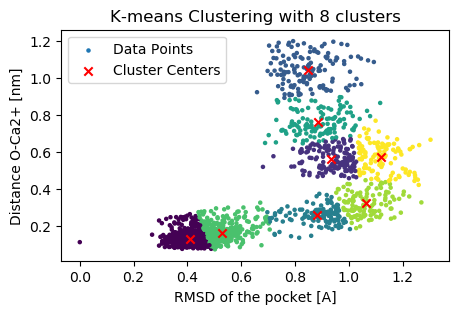

In [87]:
# Specify the number of clusters (K)
num_clusters = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data)

# Get cluster assignments and cluster centers
labels = kmeans.labels_
# The centers will be important in the remaining part of the notebook
centers = kmeans.cluster_centers_

# Plot the data points and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', s=5, label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.title(f'K-means Clustering with {num_clusters} clusters')
plt.xlabel('RMSD of the pocket [A]')
plt.ylabel('Distance O-Ca2+ [nm]')
plt.legend()
plt.show()

In [91]:
# Ora la domanda è: come posso rintracciare le configurazioni a partire dai centri?

# Assign each frame of your trajectory to the cluster whose center it is closest to. 
# This step helps categorize the trajectory frames into distinct clusters.

# Compute cluster centers and predict cluster index for each sample

# Take the labels of the previously computed clusters 
labels = kmeans.fit_predict(data)

structures = []

# Identify representative configurations for each cluster
for cluster_label in range(8):

    # I get the positions of the frames belonging to the clusters.
    # cluster_indices changes dimensions during at each iteration of the loop
    cluster_indices = np.where(labels == cluster_label)[0]

    dist = [2]
    min = 1
    for i in range(1, len(cluster_indices)):
        # I take the square of the distances
        # I loop over the set of indices associated to a given cluster
        dist.append((data[cluster_indices][i][0] - centers[cluster_label][0])**2 + (data[cluster_indices][i][1] - centers[cluster_label][1])**2)
        if min > dist[i]:
            min = dist[i]
            ref = cluster_indices[i]

    structures.append(ref)
    #structures.append(np.argmin(dist))

In [96]:
# List of the frames that have to be dumped from the fitted trajectory with 
# water on the cluster 
structures

[41, 1440, 1849, 1258, 1686, 467, 1306, 1582]

# New strategy
We always center the B point on the calcium atom and the A point on the 86TYR carbon (index 1353). 

In [2]:
str = "frames_center/frame_0.pdb"
frame = mda.Universe(str)
A = frame.select_atoms('index 1266').positions*0.1
B = frame.select_atoms('index 3261').positions*0.1
POINTS_string = A[0][0].__str__()+","+A[0][1].__str__()+","+A[0][2].__str__()+","+B[0][0].__str__()+","+B[0][1].__str__()+","+B[0][2].__str__()

In [3]:
POINTS_string

'6.5190005,5.4080005,4.579,6.4440002,4.9500003,4.298'

# Create the `funnel.dat` with the rotated funnel
I cannot rotate the box, so I rotate the funnel. I create the new `funnel.dat` starting from a template. 

In [2]:
def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(number.__str__().split('.')[1]) 
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


# Create arrays of HEIGHT, BIASFACTORS and SIGMA
HEIGHT = [1.4, 1.4, 1.2, 1.2, 1.0, 1.0, 0.8, 0.8]
BIASFACTOR = [12, 12, 10, 10, 8, 8, 7, 7]
SIGMA = [0.007, 0.007, 0.008, 0.008, 0.01, 0.01, 0.012, 0.012]


def modify_dat_file(template_file, num_files):
    for i in range(0, num_files):
        with open(template_file, 'r') as template:
            lines = template.readlines()


        # Get the coordinates
        str = f"frames_center/frame_{i}.pdb"
        frame = mda.Universe(str)
        A = frame.select_atoms('index 1266').positions*0.1
        B = frame.select_atoms('index 3261').positions*0.1
        POINTS_string = truncate(A[0][0], 3).__str__()+","+truncate(A[0][1], 3).__str__()+","+truncate(A[0][2], 3).__str__()+","+truncate(B[0][0], 3).__str__()+","+truncate(B[0][1], 3).__str__()+","+truncate(B[0][2], 3).__str__()

        # Modify the content as needed
        modified_content = []
        for line in lines:
            if "MOLINFO" in line:
                modified_content.append(f"MOLINFO STRUCTURE=ref_{i}.pdb\n")  # Modify MOLINFO line
            elif "REFERENCE=pocket.pdb" in line:
                modified_content.append(f"   REFERENCE=pocket_{i}.pdb\n")  # Modify REFERENCE line
            elif "POINTS" in line:
                modified_content.append(f"   POINTS="+POINTS_string+"\n")  # Modify POINTS line
            elif "HEIGHT" in line:
                modified_content.append(f"   HEIGHT="+HEIGHT[i].__str__()+"\n")  # Modify HEIGHT line
            elif "BIASFACTOR" in line:
                modified_content.append(f"   BIASFACTOR="+BIASFACTOR[i].__str__()+"\n")  # Modify BIASFACTOR line
            elif "SIGMA" in line:
                modified_content.append(f"   SIGMA="+SIGMA[i].__str__()+"\n")  # Modify SIGMA line
            elif "WALKERS_ID" in line:
                modified_content.append(f"   WALKERS_ID={i}\n")  # Modify ID line
            elif "REFERENCE=ref_CA.pdb" in line:
                modified_content.append(f"   REFERENCE=ref_CA_{i}.pdb\n")  # Modify REFERENCE line

            else:
                modified_content.append(line)

        # Write modified content to a new file
        with open(f"dat/funnel_{i}.dat", 'w') as modified:
            modified.writelines(modified_content)

In [3]:
# Call the function:
template_file = "funnel_template.dat"
num_files = 8  # Change this to the number of files you want to create
modify_dat_file(template_file, num_files)
print(f"{num_files} modified .dat files have been created successfully.")

8 modified .dat files have been created successfully.
